In [ ]:
import yfinance as yf
import pandas as pd 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime

In [6]:
GOLD_SYMBOL = 'GC=F' 
Start_Time = '2000-08-30'
End_time = datetime.now().strftime('%Y-%m-%d')

print(f"\n📥 تحميل بيانات الذهب من {Start_Time} إلى {End_time}")
gold_data = yf.download(GOLD_SYMBOL, start=Start_Time, end=End_time, progress=False)
extra_data = yf.download(['DX-Y.NYB', '^TNX', '^GSPC'], start=Start_Time, end=End_time, progress=False)['Close']
    
gold_data.to_csv('gold.csv')

data = pd.read_csv('gold.csv', skiprows=2) 


data=data.rename(columns={
    'Unnamed: 1':'Close',
    'Unnamed: 2':'High',
    'Unnamed: 3':'Low',
    'Unnamed: 4':'Open',
    'Unnamed: 5':'Volume'
})



data['SMA_10']=data['Close'].rolling(window=10).mean()
data['SMA_30']=data['Close'].rolling(window=30).mean()

data['EMA_10']=data['Close'].ewm(span=10 ,adjust=False ).mean()
data['EMA_30']=data['Close'].ewm(span=30 ,adjust=False ).mean()

data['vol_10']=data['Close'].rolling(window=10).std()

data['Daily_return'] = data['Close'].pct_change() *100

data['Close_Diff']=data['Close'].diff()


data=data.sort_values('Date').set_index('Date')

extra_data = extra_data.reindex(data.index)

data["DX-Y.NYB"] = extra_data["DX-Y.NYB"]
data["^TNX"] = extra_data["^TNX"]
data["^GSPC"] = extra_data["^GSPC"]

data=data.drop_duplicates()
# تحويل الأعمدة إلى نوع رقمي (قد تكون تحولت إلى Object بسبب skiprows)
data = data.apply(pd.to_numeric, errors='coerce').dropna()




📥 تحميل بيانات الذهب من 2000-08-30 إلى 2025-12-13


C:\Users\ahmed\AppData\Local\Temp\ipykernel_12728\913744351.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  gold_data = yf.download(GOLD_SYMBOL, start=Start_Time, end=End_time, progress=False)
C:\Users\ahmed\AppData\Local\Temp\ipykernel_12728\913744351.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  extra_data = yf.download(['DX-Y.NYB', '^TNX', '^GSPC'], start=Start_Time, end=End_time, progress=False)['Close']


In [91]:
data.shape[1]

15

In [8]:
tf.random.set_seed(42)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

scaled_data = scaler.fit_transform(data)
scaled_data_df = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)

split_index=int(len(scaled_data_df) * 0.90)
train_set = scaled_data_df[:split_index]
test_set = scaled_data_df[split_index:]

seq_length=90
num_features = train_set.shape[1] 

close_index = data.columns.get_loc('Close')

train_targets = train_set.iloc[seq_length:, close_index].to_numpy()
test_targets = test_set.iloc[seq_length:, close_index].to_numpy()


train_ds=tf.keras.utils.timeseries_dataset_from_array(
    train_set.to_numpy(),
    targets=train_targets,
    sequence_length=seq_length,
    shuffle=True,
    batch_size=32,
    seed=42
)

test_ds=tf.keras.utils.timeseries_dataset_from_array(
    test_set.to_numpy(),
    targets=test_targets,
    sequence_length=seq_length,
    batch_size=32
)

In [ ]:
model_improved = tf.keras.Sequential([
    tf.keras.layers.LSTM(194, return_sequences=True, input_shape=(seq_length, num_features)),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(96, activation='relu'),
    tf.keras.layers.Dense(1)
])

c:\Users\ahmed\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [94]:
early_stopping=tf.keras.callbacks.EarlyStopping(
     monitor='val_mae', patience=30 , restore_best_weights=True
 )
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model2.keras', save_best_only=True)


In [95]:
opt_nadam = opt_nadam = tf.keras.optimizers.Nadam(learning_rate=0.001)

model_improved.compile(loss=tf.keras.losses.Huber() , optimizer = opt_nadam , metrics=['mae'])
history=model_improved.fit(train_ds , epochs=100 , callbacks=[ early_stopping , checkpoint ] , validation_data = test_ds)

Epoch 1/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step - loss: 2.5349e-04 - mae: 0.0098 - val_loss: 0.0017 - val_mae: 0.0425
Epoch 2/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 3.5676e-05 - mae: 0.0063 - val_loss: 0.0012 - val_mae: 0.0457
Epoch 3/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - loss: 2.8479e-05 - mae: 0.0054 - val_loss: 5.4229e-04 - val_mae: 0.0226
Epoch 4/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - loss: 2.7445e-05 - mae: 0.0052 - val_loss: 3.1652e-04 - val_mae: 0.0171
Epoch 5/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - loss: 2.1797e-05 - mae: 0.0049 - val_loss: 2.4683e-04 - val_mae: 0.0159
Epoch 6/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 2.1063e-05 - mae: 0.0048 - val_loss: 5.5031e-04 - val_mae: 0.0262
Epoch 7/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 2.1315e-05 - mae: 0.0048 - val_loss: 1.2394e-04 - val_mae: 0.0116
Epoch 8/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 1.7874e-05 - mae: 0.0043 - val_loss: 1.0375e

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


C:\Users\ahmed\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


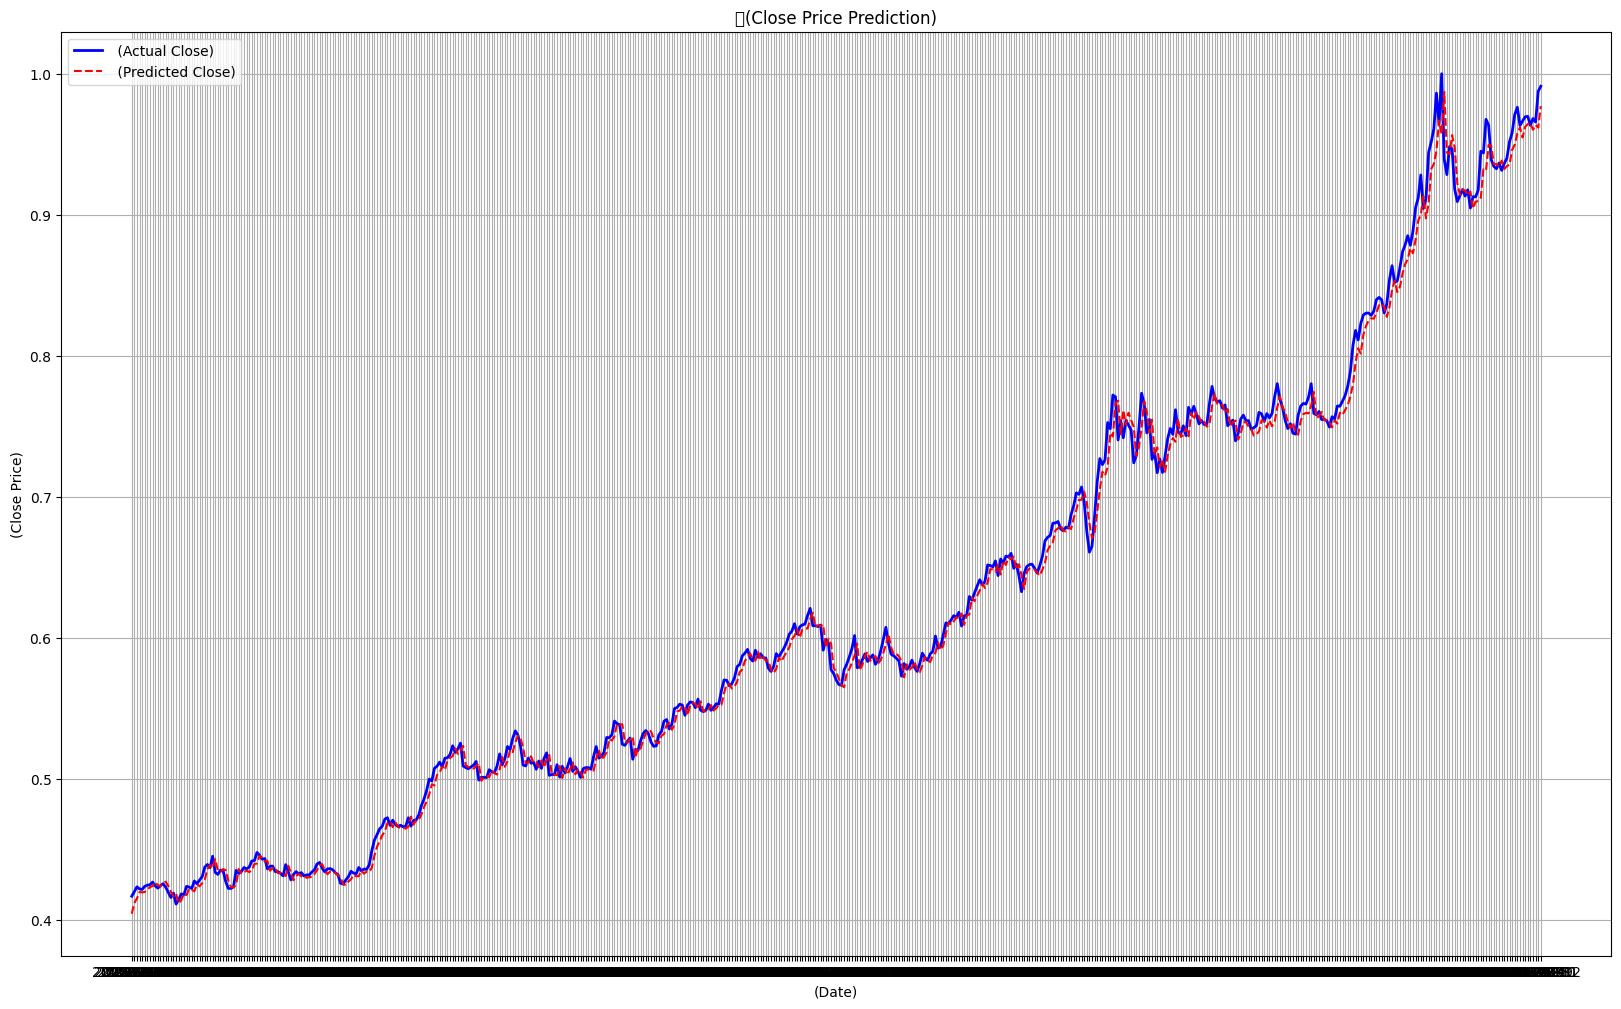

In [9]:
# import tf_keras

model_improved = tf.keras.models.load_model('best_model2.keras')

predictions = model_improved.predict(test_ds)
actual_targets = test_set['Close'].iloc[seq_length:].to_numpy()

date_index = test_set.index[seq_length:]

results_df = pd.DataFrame({
    'Actual_Close': actual_targets.flatten(),
    'Predicted_Close': predictions.flatten()
}, index=date_index)

plt.figure(figsize=(20, 12))
plt.title('📈(Close Price Prediction)')
plt.plot(results_df['Actual_Close'], label=' (Actual Close)', color='blue', linewidth=2)
plt.plot(results_df['Predicted_Close'], label=' (Predicted Close)', color='red', linestyle='--')
plt.xlabel('(Date)')
plt.ylabel('(Close Price)')
plt.legend()
plt.grid(True)
plt.show()